## 종목별 핫이슈 키워드 전처리 + 키워드 기반 종목 추천

In [17]:
import numpy as np
import re
import pandas as pd
import csv
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras
from konlpy.tag import Okt
from math import log, exp
import collections
from collections import Counter
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
df = pd.read_csv('종목별 핫이슈 키워드.csv')

# 필요한 컬럼만 사용
data = df[['ITMT_CD_NM','ISSUE_CTNT']]

#  전처리
data['ISSUE_CTNT'][0][1:-1]

def preprocess(str_list):
    p = re.compile("'.+?'")
    matched = p.findall(str_list)

    w_list = []
    for w in matched:
        kor = w.replace("'",'')
        if kor != 'words' and kor != 'wordweights':
            w_list.append(kor)
    
    return w_list

kor_data = []
for w in data['ISSUE_CTNT']:
    kor_list = preprocess(w[1:-1])
    kor_data.append(kor_list)

df1 = pd.DataFrame({'words': kor_data})
df2 = pd.DataFrame({'name': data['ITMT_CD_NM']})
df_keyword = pd.merge(df2, df1, left_index=True, right_index=True, how='left')

## seq2seq

In [13]:
# seq2seq 인코더 디코더 설정
encoder_input, decoder_input, decoder_output = [], [], []

for word in df_keyword['words']:
    encoder_input.append(word)

for name in df_keyword['name']:
    decoder_input.append(("<start> " + name).split())

for name in df_keyword['name']:
    decoder_output.append((name+" <end>").split())

In [14]:
# 확인
print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_output[:3])

[['임상', '미', '약품', '스펙트럼', '코호트', '신약', '포지오', '티', '환자', '평가', '약품', '미', '제약', '에페', '글', '타이드', '레나', '사노', '피', '경제', '약품', '미', '탄', '신약', '잘탄', '패밀리', '매출', '아모', '개발', '경제', '임상', '기술', '바이오', '제약', '치료제', '밝혔', '받', '환자', '평가', '병원', '약품', '미', '사노', '피', '글', '에페', '레나', '타이드', '경제', '개발'], ['정세균', '중공업', '수산', '관련', '알루코', '한경', '총리', '경제', '주가', '급등', '수산', '중공업', '배', '경제', '서울', 'PER', 'PBR', '업종', '차트', '정배', '분기', '이익', '영업', '매출액', '한국', '중공업', '수산', '경제', '흑자', '전환'], ['수송관', '시험', '성능', '한난', '센터', '경제', '한국지역난방공사', '안전', '사업', '사장']]
[['<start>', '한미약품'], ['<start>', '수산중공업'], ['<start>', '지역난방공사']]
[['한미약품', '<end>'], ['수산중공업', '<end>'], ['지역난방공사', '<end>']]


In [15]:
# 우리의 데이터는 이미 단어별로 나누어져있음
# 단어 토큰화 생략, but 정수 인코딩은 필요

# fit_on_texts : 입력한 텍스트로부터 단어 빈도수가 높은 순으로 낮은 정수 인덱스 부여
# fit_on_texts()안에 코퍼스를 입력으로 하면 빈도수를 기준으로 단어 집합을 생성

tokenizer_ko = Tokenizer()
tokenizer_ko.fit_on_texts(encoder_input)
encoder_input = tokenizer_ko.texts_to_sequences(encoder_input)

tokenizer_ko.fit_on_texts(decoder_input)
tokenizer_ko.fit_on_texts(decoder_output)

decoder_input = tokenizer_ko.texts_to_sequences(decoder_input)
decoder_output = tokenizer_ko.texts_to_sequences(decoder_output)

In [16]:
# 확인
print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_output[:3])

[[62, 276, 191, 6083, 6272, 256, 6084, 126, 202, 227, 191, 276, 60, 3751, 456, 2945, 3702, 3105, 307, 1, 191, 276, 1486, 256, 6836, 4510, 38, 3427, 27, 1, 62, 48, 44, 60, 80, 1161, 67, 202, 227, 480, 191, 276, 3105, 307, 456, 3751, 3702, 2945, 1, 27], [7669, 128, 2424, 335, 9325, 9, 2633, 1, 21, 1942, 2424, 128, 24, 1, 58, 55, 47, 96, 14, 75, 5, 10, 4, 31, 2, 128, 2424, 1, 189, 125], [4912, 352, 1893, 3311, 165, 1, 2654, 284, 11, 138]]
[[2, 1391], [2, 4549], [2, 1712]]
[[1391, 3], [4549, 3], [1712, 3]]


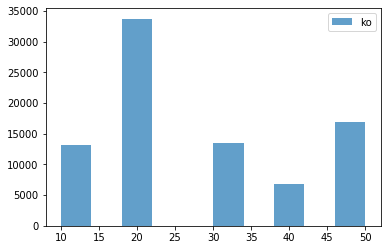

In [18]:
# 패딩을 하기 위해 encoderd의 길이 파악
len_ko = []
for data in encoder_input:
    len_ko.append(len(data))

plt.hist(len_ko, label='ko', alpha=0.7)
plt.legend()
plt.show()

In [19]:
# 패딩을 수행
# 기본적으론 앞에 0를 붙이는데, post를 쓰면 뒤에 패딩이 됨
encoder_input = pad_sequences(encoder_input, padding="post")

# 디코더는 길이가 다 2이므로 패딩이 필요없다.
decoder_input = pad_sequences(decoder_input, padding="post")
decoder_output = pad_sequences(decoder_output, padding="post")

In [21]:
print(encoder_input[:3])
print(decoder_input[:3])
print(decoder_output[:3])

[[  62  276  191 6083 6272  256 6084  126  202  227  191  276   60 3751
   456 2945 3702 3105  307    1  191  276 1486  256 6836 4510   38 3427
    27    1   62   48   44   60   80 1161   67  202  227  480  191  276
  3105  307  456 3751 3702 2945    1   27]
 [7669  128 2424  335 9325    9 2633    1   21 1942 2424  128   24    1
    58   55   47   96   14   75    5   10    4   31    2  128 2424    1
   189  125    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]
 [4912  352 1893 3311  165    1 2654  284   11  138    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0]]
[[   2 1391    0]
 [   2 4549    0]
 [   2 1712    0]]
[[1391    3    0]
 [4549    3    0]
 [1712    3    0]]


In [22]:
# 나중에 prediction 할때 사용하기 위함 (인덱스로 단어 찾기)
en_to_index = tokenizer_ko.word_index
index_to_en = tokenizer_ko.index_word

In [23]:
# 3:1 비율로 test_size와 train_size 설정
test_size = 62000
encoder_input_train = encoder_input[:-test_size]
decoder_input_train = decoder_input[:-test_size]
decoder_output_train = decoder_output[:-test_size]

encoder_input_test = encoder_input[-test_size:]
decoder_input_test = decoder_input[-test_size:]
decoder_output_test = decoder_output[-test_size:]

## training

In [68]:
# 인코더 모델
encoder_inputs = Input(shape=(50,)) 
encoder_embed = Embedding(len(tokenizer_ko.word_index)+1, 50)(encoder_inputs)
encoder_mask = Masking(mask_value=0)(encoder_embed)
encoder_outputs, h_state, c_state = LSTM(50, return_state=True)(encoder_mask)

In [69]:
# 디코더 모델
decoder_inputs = Input(shape=(3,))  
decoder_embed = Embedding(len(tokenizer_ko.word_index)+1, 50)(decoder_inputs)
decoder_mask = Masking(mask_value=0)(decoder_embed)
decoder_lstm = LSTM(50, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_mask, initial_state=[h_state, c_state])
decoder_dense = Dense(len(tokenizer_ko.word_index)+1, activation='softmax')
decoder_softmax_outputs = decoder_dense(decoder_outputs)

In [70]:
# 모델 설정 및 학습
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_output_train, validation_data = ([encoder_input_test, decoder_input_test], decoder_output_test), batch_size = 128, epochs = 10)

Epoch 1/10
173/173 [==============================] - 69s 399ms/step - loss: 4.4969 - acc: 0.3532 - val_loss: 3.2912 - val_acc: 0.6607
Epoch 2/10
173/173 [==============================] - 68s 390ms/step - loss: 2.6553 - acc: 0.6609 - val_loss: 2.8736 - val_acc: 0.6629
Epoch 3/10
173/173 [==============================] - 65s 377ms/step - loss: 2.3468 - acc: 0.6632 - val_loss: 2.8205 - val_acc: 0.6636
Epoch 4/10
173/173 [==============================] - 66s 382ms/step - loss: 2.2129 - acc: 0.6635 - val_loss: 2.8229 - val_acc: 0.6639
Epoch 5/10
173/173 [==============================] - 68s 395ms/step - loss: 2.0924 - acc: 0.6647 - val_loss: 2.9239 - val_acc: 0.6648
Epoch 6/10
173/173 [==============================] - 69s 399ms/step - loss: 1.9870 - acc: 0.6660 - val_loss: 2.9026 - val_acc: 0.6654
Epoch 7/10
173/173 [==============================] - 69s 396ms/step - loss: 1.8925 - acc: 0.6670 - val_loss: 2.7962 - val_acc: 0.6663
Epoch 8/10
173/173 [==============================] - 6

## Prediction

In [71]:
# 성능평가를 위한 인코더 모델 생성
encoder_model = Model(encoder_inputs, [h_state, c_state])
encoder_h_state = Input(shape=(50,))
encoder_c_state = Input(shape=(50,))

In [73]:
# 디코더 모델 생성
pd_decoder_outputs, pd_h_state, pd_c_state = decoder_lstm(decoder_mask, initial_state=[encoder_h_state, encoder_c_state])
pd_decoder_softmax_outputs = decoder_dense(pd_decoder_outputs)
decoder_model = Model([decoder_inputs] + [encoder_h_state, encoder_c_state], [pd_decoder_softmax_outputs] + [pd_h_state, pd_c_state])

In [75]:
# 키워드 입력
input_stc = input()

token_stc = input_stc.split()
encode_stc = tokenizer_ko.texts_to_sequences([token_stc])
pad_stc = pad_sequences(encode_stc, maxlen=50, padding="post")

# 인코더의 마지막 시점의 셀/은닉 상태 값
states_value = encoder_model.predict(pad_stc)

# <start> 를 정수 인코딩해서 numpy array 로
predicted_seq = np.zeros((1,1))
predicted_seq[0, 0] = en_to_index['<start>']

# 각 시점마다 예측된 단어를 저장
decoded_stc = []

while True:
    output_words, h, c = decoder_model.predict([predicted_seq] + states_value)
    predicted_word = index_to_en[np.argmax(output_words[0,0])]  

    # end 가 나오면 끝
    if predicted_word == '<end>':
        break

    decoded_stc.append(predicted_word)

    # 처음에는 <start>, 지금은 예측된 단어가 있으니 이것을 인풋으로 넣어주기 위해서 변수의 값을 업데이트
    predicted_seq = np.zeros((1,1))
    predicted_seq[0, 0] = np.argmax(output_words[0,0])

    # 지금 시점의 상태 값을 다음 시점으로 넘기기 위해서 변수를 업데이트
    states_value = [h, c]

print(' '.join(decoded_stc))

임상 신약 치료제 대한민국
화이브라더스코리아


## 종목별 뉴스 분석 감정평가 + 나이브베이즈 모델을 이용한 감정평가

In [38]:
# 데이터 전처리 함수
def csv_processing():
    df = pd.read_csv("종목별뉴스분석감정평가.csv")
    
    # 필요없는 컬럼 삭제
    del df['ITMT_CD_NM']
    del df['ORG_TITL_NM']
    del df['ORG_CTGO_NM']
    del df['URL_ADDR']
    del df['STRD_DTM']
    del df['ZP']
    del df['LOAD_DTM']
    del df['CENTER_CD']
    
    # 모델을 학습할때 긍정과 부정 데이터 수가 비슷하면 
    # 성능이 좋아지기 때문에 먼저 중립데이터 행을 제거한 후
    # 긍정과 부정 비율을 비슷하게 맞춰준다 
    
    # 보기 쉽게 데이터 컬럼명 바꾸기
    df.rename(columns={"STRD_YYMMDD":"기준일자",'ITMT_CD_NM.1':'주식종목명','ORG_CTNT':'원문내용','BEM_IDEX_VAL':'감성지표값','SCR_CTGO_NM':'스코어분류명'}, inplace=True)
    
    # 중립데이터 제거
    df1 = df[df['스코어분류명']=='중립'].index
    df1 = df.drop(df1)
    
    # 주식종목명당 기사가 14개 미만인 종목을 결측치로 취급하여 제거
    df.groupby(df['주식종목명']).count().sort_values(by=['기준일자'],ascending=False)
    xx =df.groupby(df['주식종목명']).count().sort_values(by=['기준일자'],ascending=False)
    aa = xx[xx['기준일자']>14]
    index_list = list(aa.index)
    
    for i in range(0,len(df)):
        if df.iloc[i,1] not in index_list:
            df.iloc[i,1] = np.nan
        
    df.dropna(inplace =True)
    # 종목마다 긍정 부정인 판별이 다르기 때문에 원문 내용에 주식종목명 추가
    df['원문내용'] = df['주식종목명'] + ' ' + df['원문내용']
        
    return df

In [39]:
# test_datas 생성
def test_datas():
    df = csv_processing()
    
    pos_doc = []
    neg_doc = []
    
    for i in range(0,len(df)):
        if df.iloc[i,4] == '긍정':
            pos_doc.append(df.iloc[i,2])
        else:
            neg_doc.append(df.iloc[i,2])
            
    # pos_doc 길이 71871, neg_doc 길이 21094
    # 학습시킬 데이터와 테스트 데이터 양을 같게 만들어줌
    # 여기서는 test를 5000개, 대략 3:1 비율         
         
    train_datas = [[], []]
    train_datas[0] = neg_doc[:16094]
    train_datas[1] = pos_doc[:16094]
    df = [neg_doc[16094:], pos_doc[16094:21094]]
    
    ## 오래 걸려서 test 10개만 
    #train_datas = [[], []]
    #train_datas[0] = neg_doc[:19332]
    #train_datas[1] = pos_doc[:19332]
    #test_datas = [neg_doc[19332:19342], pos_doc[19332:19342]]
    
    return df


In [ ]:
# 분류 시작 함수
def start():
    train_datas = open_csv()
    df_t = test_datas()
    df_tests = pd.DataFrame({'부정':df_t[0],'긍정':df_t[1]})
    
    count = 0
    for i in range(0,5000):
        test_data = df_tests['부정'][i]
        prob = naive_bayes(train_datas, test_data, 0.5, 0.5)
        if prob[0] >= prob[1]:
            count += 1
    print(f'부정일때 정확도 :{count/5000*100}')
    
    # 오래걸려서 10개만 
    #for i in range(0,10):
    #    test_data = df_tests['부정'][i]
    #    prob = naive_bayes(train_datas, test_data, 0.5, 0.5)
    #    if prob[0] >= prob[1]:
    #        count += 1
    #print(f'부정일때 정확도 :{count/10*100}')
    
    count = 0
    for i in range(0,5000):
        test_data = df_tests['긍정'][i]
        prob = naive_bayes(train_datas, test_data, 0.5, 0.5)
        if prob[0] <= prob[1]:
            count += 1
    print(f'긍정일때 정확도 :{count/5000*100}')
    
    # 오래걸려 10개만
    #count = 0
    #for i in range(0,10):
    #    test_data = df_tests['긍정'][i]
    #    prob = naive_bayes(train_datas, test_data, 0.5, 0.5)
    #    if prob[0] <= prob[1]:
    #        count += 1
    #print(f'긍정일때 정확도 :{count/10*100}')
    
    train_datas = open_csv()
    df_tests = test_datas()
    test_dt= [' '.join(df_tests[0]), ' '.join(df_tests[1])]
    
    prob = naive_bayes(train_datas, test_dt[1], 0.5, 0.5)
    print(f'긍정적인 데이터가 부정적일 확률 : {prob[0]}, 긍정적일 확률 : {prob[1]}')
    
    # 부정인 문장을 넣고, 실제로 부정이라고 나오는지 확인
    prob = naive_bayes(train_datas, test_dt[0], 0.5, 0.5)
    print(f'부정적인 데이터가 부정적일 확률 : {prob[0]}, 긍정적일 확률 : {prob[1]}')
    
# 전처리된 dataframe 불러와 train_set 생성    
def open_csv():
    df = csv_processing()
    
    pos_doc = []
    neg_doc = []
    
    for i in range(0,len(df)):
        if df.iloc[i,4] == '긍정':
            pos_doc.append(df.iloc[i,2])
        else:
            neg_doc.append(df.iloc[i,2])
            
    train_datas = [[], []]
    train_datas[0] = neg_doc[:16094]
    train_datas[1] = pos_doc[:16094]
    
    #오래걸려 10개만
    #train_datas = [[], []]
    #train_datas[0] = neg_doc[:19332]
    #train_datas[1] = pos_doc[:19332]
    
    # 리스트 형태는 토큰화하기가 어렵기 때문에, 전부 조인을 해서 하나의 문자열로 만들어준다
    return [' '.join(train_datas[0]), ' '.join(train_datas[1])]

# 스탑워드 제거, 토큰화, Bow화 함수
# 단어 수가 늘어나면 단어별 확률이 소실될 수 있는데
# 이를 방지하고 값을 간략하게 저장하게 위해서 로그를 취한다
def calculate_doc_prob(train_data, test_data, nowords_weight):
    # 스탑워드 제거
    sw_train_data = re.compile('[^\w]').sub(' ', train_data.lower())
    # 토큰화
    sw_train_token = sw_train_data.split()
    # Bow화 (단어 : 빈도수 형태)
    train_vector = dict(Counter(sw_train_token))

    # 스탑워드 제거
    sw_test_data = re.compile('[^\w]').sub(' ', test_data.lower())
    # 토큰화
    sw_test_token = sw_test_data.split()
    # Bow화 (단어 : 빈도수 형태)
    test_vector = dict(Counter(sw_test_token))
    total_wc = len(sw_train_token)
    log_prob = 0

    # log(P(test_data|긍정))
    # 단어 10개로 이루어진 문장, 각 단어가 나올 확률이 (10/500000) -> 문장이 나올 확률은 0.00000000000000000000000000000000000000001024
    # e.1024e-50 -> 0 -> (로그함수) -50
    # 확률이 소실되는 것을 방지하고, 값을 간략하게 저장하게 위해서 로그를 취한다
    for word in test_vector:
        if word in train_vector:
            log_prob += log(train_vector[word]/total_wc)
        else:
            # train 데이터셋에 없는 단어가 나왔으면... 해당 단어가 나올 확률 추정불가
            # 해당 단어의 빈도수
            # 빈도수가 없는 단어는 우리가 빈도를 지정하주자!
            log_prob += log(nowords_weight/total_wc)

    return log_prob

# 긍정, 부정의 크기를 상대적인 크기로 정규화
# 두 확률 값의 상대적인 비율을 return
def naive_bayes(train_datas, test_data, pos_prob, neg_prob):
    # P(긍정|test_data) = P(test_data|긍정) * P(긍정) / P(test_data)
    test_pos_prob = calculate_doc_prob(train_datas[1], test_data, 0.1) + log(pos_prob) 
    # P(부정|test_data) = P(test_data|부정) * P(부정) / P(test_data)
    test_neg_prob = calculate_doc_prob(train_datas[0], test_data, 0.1) + log(neg_prob) 

    # 10 : 5 -> 2 : 1
    # 긍정, 부정의 상대적인 크기
    # test_pos_prob (로그값) -> 로그값 -50 -> 지수함수 0에 수렴
    # test_neg_prob (로그값) -> 로그값 -50 -> 지수함수 0에 수렴
    # 로그함수 -> logex, 지수함수 -> e**x
    # -50, -52 -> (지수화) e**-50=0, e**-52=0
    # -50, -52 -> 0, -2 -> (지수화) e**0 = 1, e**-2 = 0.12
    # 긍정 확률 1, 부정 확률 0.12 -> 1/1+0.12, 0.12/1+0.12
    maxprob = max(test_neg_prob, test_pos_prob)
    test_neg_prob -= maxprob
    test_pos_prob -= maxprob
    #print(test_neg_prob, test_pos_prob)
    test_neg_prob = exp(test_neg_prob)
    test_pos_prob = exp(test_pos_prob)
    # 두 확률 값의 상대적인 비율
    normalized_prob = [test_neg_prob/(test_neg_prob+test_pos_prob), test_pos_prob/(test_neg_prob+test_pos_prob)]

    return normalized_prob

start()

부정일때 정확도 :58.84
긍정일때 정확도 :70.36


## 유사도 기반 종목 추천

In [25]:
datas = pd.read_csv('종목별 핫이슈 키워드.csv')

In [26]:
# 데이터 전처리
datas['ISSUE_CTNT'] = datas['ISSUE_CTNT'].apply(literal_eval)
datas['ISSUE_CTNT'] = datas['ISSUE_CTNT'].apply(lambda x : [y['words'] for y in x])

for i in range(0,len(datas)):
    l = len(datas['ISSUE_CTNT'][i])
    x_list = []
    for j in range(0,l):
        x = datas['ISSUE_CTNT'][i][j]
        x_list = x_list + x
    datas['ISSUE_CTNT'][i] = x_list
    
# 리스트 형태는 토큰화하기가 어렵기 때문에, 전부 조인을 해서 하나의 문자열로 만들어준다
datas['ISSUE_CTNT'] = datas['ISSUE_CTNT'].apply(lambda x : ' '.join(x))

C:\Users\kbp41\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [27]:
# 10개만 (컴퓨팅 파워 문제)
stock = datas[:10]

# ngram_range=(1, 2) 는 단어를 1개 혹은 2개 연속으로 보겠다
tfidf_vec = TfidfVectorizer(ngram_range=(1, 2))
# ketwords 대신 ISSUE_CTNT사용
tfidf_matrix = tfidf_vec.fit_transform(stock['ISSUE_CTNT'])
print(tfidf_vec.vocabulary_.items())
# 10은 종목의 개수, 336은 단어의 개수 -> 하나의 주식를 336개 열을 가진 벡터로 표현
print(tfidf_matrix.shape)

dict_items([('임상', 236), ('약품', 205), ('스펙트럼', 179), ('코호트', 285), ('신약', 191), ('포지오', 308), ('환자', 327), ('평가', 305), ('제약', 252), ('에페', 213), ('타이드', 291), ('레나', 102), ('사노', 146), ('경제', 32), ('잘탄', 241), ('패밀리', 300), ('매출', 112), ('아모', 196), ('개발', 27), ('기술', 68), ('바이오', 122), ('치료제', 283), ('밝혔', 128), ('병원', 136), ('임상 약품', 238), ('약품 스펙트럼', 207), ('스펙트럼 코호트', 180), ('코호트 신약', 286), ('신약 포지오', 193), ('포지오 환자', 309), ('환자 평가', 328), ('평가 약품', 307), ('약품 제약', 209), ('제약 에페', 254), ('에페 타이드', 215), ('타이드 레나', 293), ('레나 사노', 103), ('사노 경제', 147), ('경제 약품', 38), ('약품 신약', 208), ('신약 잘탄', 192), ('잘탄 패밀리', 242), ('패밀리 매출', 301), ('매출 아모', 113), ('아모 개발', 197), ('개발 경제', 28), ('경제 임상', 40), ('임상 기술', 237), ('기술 바이오', 70), ('바이오 제약', 123), ('제약 치료제', 255), ('치료제 밝혔', 284), ('밝혔 환자', 129), ('평가 병원', 306), ('병원 약품', 137), ('약품 사노', 206), ('사노 에페', 148), ('에페 레나', 214), ('레나 타이드', 104), ('타이드 경제', 292), ('경제 개발', 33), ('정세균', 248), ('중공업', 265), ('수산', 171), ('관련', 53), ('알루코', 203),

In [28]:
# 유사도 행렬 (10, 10)
# 1, 1 / 1, 2 / .... / 1, 10 -> 1번째 주식와 1~10번재 주식의 유사도
# 2, 1 / 2, 2 / .... / 2, 10 -> 2번째 주식와 1~10번째 주식의 유사도

genres_similarity = cosine_similarity(tfidf_matrix, tfidf_matrix)
print(genres_similarity)

# 유사도 값이 높은 순으로 인덱스 값을 뽑아낸다
similar_index = np.argsort(-genres_similarity)
print(similar_index)

[[1.         0.02148812 0.01348856 0.0252953  0.00904519 0.01455037
  0.02083305 0.         0.01884108 0.008866  ]
 [0.02148812 1.         0.01768577 0.01658319 0.01185977 0.24681774
  0.04627423 0.         0.05956552 0.03671185]
 [0.01348856 0.01768577 1.         0.         0.00744464 0.01197566
  0.03752858 0.03705548 0.00801132 0.00729715]
 [0.0252953  0.01658319 0.         1.         0.         0.
  0.         0.         0.02253561 0.        ]
 [0.00904519 0.01185977 0.00744464 0.         1.         0.00803067
  0.02516602 0.         0.02507347 0.01862875]
 [0.01455037 0.24681774 0.01197566 0.         0.00803067 1.
  0.01409909 0.         0.00864196 0.02996675]
 [0.02083305 0.04627423 0.03752858 0.         0.02516602 0.01409909
  1.         0.02908391 0.02978625 0.09817955]
 [0.         0.         0.03705548 0.         0.         0.
  0.02908391 1.         0.         0.        ]
 [0.01884108 0.05956552 0.00801132 0.02253561 0.02507347 0.00864196
  0.02978625 0.         1.         0

In [37]:
# 사용자가 입력한 주식의 인덱스 값을 찾아내고
# similar_index 에 기록된 유사한 주식 인덱스를 찾아내고
# 유사한 인덱스를 토대로 주식을 찾아내면 된다!
input_stock = input()

stock_index = stock[stock['ITMT_CD_NM'] ==input_stock].index.values
#print(stock_index)
similar_stock = similar_index[stock_index, 1:3]
#print(similar_stock)
# 인덱스로 사용하기 위해서는 1차원으로 변형해줘야하기 때문
similar_stock_index = similar_stock.reshape(-1)
#print(similar_stock_index)
print(stock.iloc[similar_stock_index])

한미약품
   STRD_DATE  STCK_ITMT_CD_NM ITMT_CD_NM  \
3   20200102            66430       와이오엠   
1   20200102            17550      수산중공업   

                                          ISSUE_CTNT  ISSUE_CTGO_USE_DOC_NUM  \
3  소송 회사 주장 엠 박모 제기 법 대응 채권자 씨 엠 포토 지난 주가 공급 이오 동...                       6   
1  정세균 중공업 수산 관련 알루코 한경 총리 경제 주가 급등 수산 중공업 배 경제 서...                      13   

        ZP LOAD_DTM CENTER_CD  
3  46729.0   ZZZZZZ     BBP14  
1  18628.0   ZZZZZZ     BBP14  


## 1순위 와이오엠, 2순위 수산중공업